In [40]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

In [41]:
raw = pd.read_excel('views_medium_mes.xlsx')

## Exploratória

In [42]:
data = raw.copy()
df = data.set_index('data')

df.shape

(27, 4)

In [43]:
df.head()

,visualizacoes,post,impressions_linkedin,lockdown
data,,,,
2020-04-01,141.0,1,10050,1
2020-05-01,22.0,0,0,1
2020-06-01,155.0,1,21131,1
2020-07-01,73.0,0,0,1
2020-08-01,84.0,0,0,0


In [44]:
#log no y
df['visualizacoes_log'] = np.log10(df.visualizacoes)

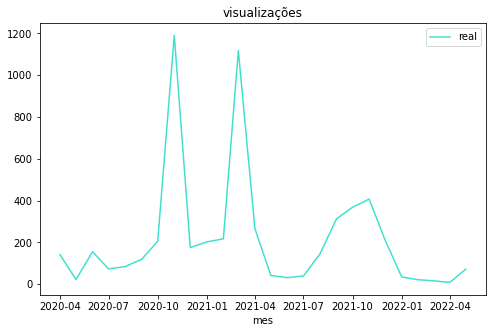

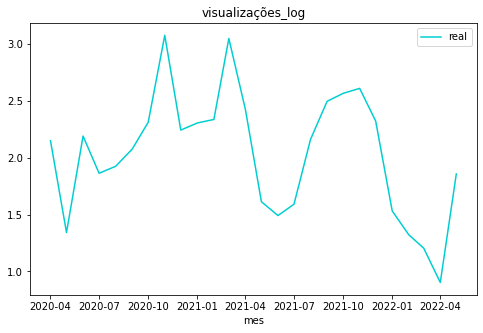

In [45]:
plt.subplots(figsize=(8, 5))
plt.plot(df.visualizacoes.dropna(), color='turquoise', label='real')
plt.title("visualizações")
plt.xlabel("mes")
plt.legend()
plt.show()

plt.subplots(figsize=(8, 5))
plt.plot(df.visualizacoes_log.dropna(), color='darkturquoise', label='real')
plt.title("visualizações_log")
plt.xlabel("mes")
plt.legend()
plt.show()



In [46]:
df_real = df[df.visualizacoes.notnull()]
df_future = df[df.visualizacoes.isnull()]

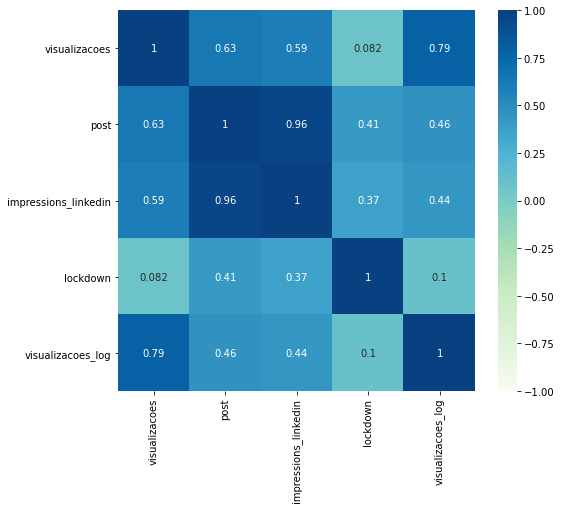

In [47]:
plt.figure(figsize=(8, 7))
sns.heatmap(df_real.corr(), annot=True,vmin=-1, vmax=1,center= 0, cmap='GnBu')
plt.show()

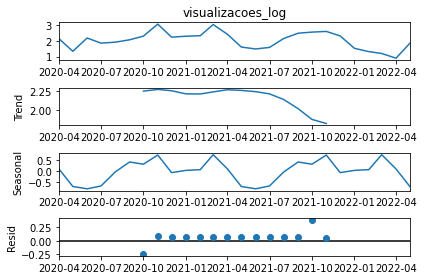

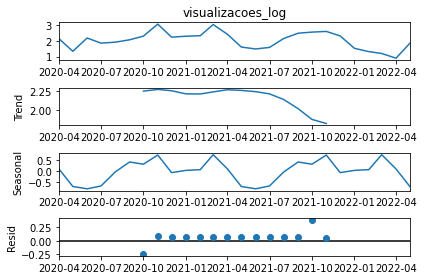

In [48]:
decomposicao = seasonal_decompose(df_real.visualizacoes_log, period = 12)

decomposicao.plot()

In [49]:
#calculando a primeira diferenciacao da serie
first_diff = df_real.visualizacoes_log.diff().dropna()

In [50]:
#teste de estacionariedade - Dickey-Fuller
def adfuller_test(serie):

    test = adfuller(serie, autolag='AIC')
    output = pd.Series(test[0:2], index=['test adfuller','p-value'])

    return output

In [51]:
#teste de estacionariedade na serie com log
adfuller_test(df_real.visualizacoes_log)

test adfuller   -2.568984
p-value          0.099579
dtype: float64

In [52]:
#teste de estacionariedade na serie com log com a primeira diferenciacao
adfuller_test(first_diff)

test adfuller   -5.277765
p-value          0.000006
dtype: float64

In [53]:
#teste de estacionariedade no componente sazonal
adfuller_test(decomposicao.seasonal)

test adfuller   -3.840342
p-value          0.002521
dtype: float64

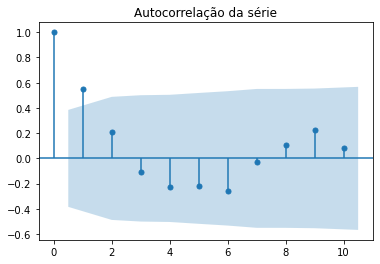

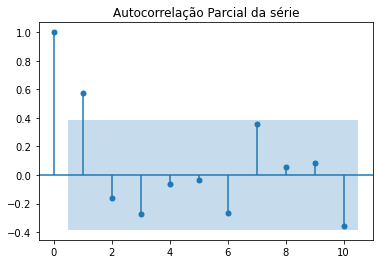

In [54]:
#ACF e PACF da serie em log

plot_acf(df.visualizacoes_log.dropna(), lags=10, title = "Autocorrelação da série")
plot_pacf(df.visualizacoes_log.dropna(), lags=10, title = "Autocorrelação Parcial da série")

plt.show()

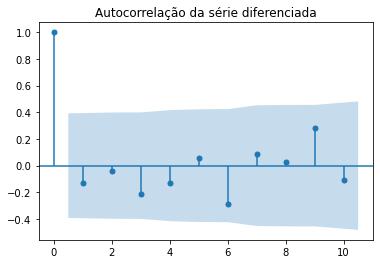

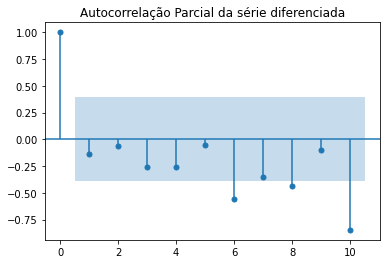

In [55]:
#ACF e PACF da primeira diferenciacao

plot_acf(first_diff, lags=10,  title = "Autocorrelação da série diferenciada")
plot_pacf(first_diff, lags=10, title = "Autocorrelação Parcial da série diferenciada")

plt.show()

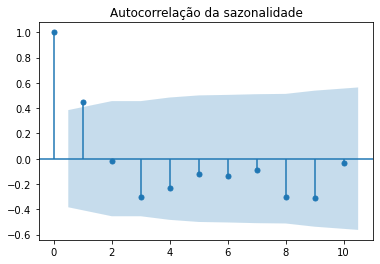

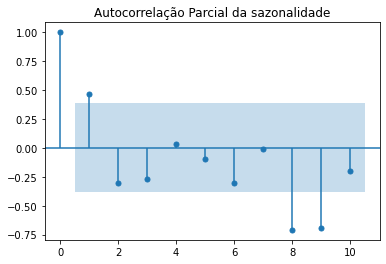

In [56]:
#ACF e PACF da componente sazonal

plot_acf(decomposicao.seasonal, lags=10, title = "Autocorrelação da sazonalidade")
plot_pacf(decomposicao.seasonal, lags=10, title = "Autocorrelação Parcial da sazonalidade")

plt.show()

## Modelagem

In [57]:
#treino e teste
train = df_real.loc[df_real.index < '2021-11-01']
test = df_real.loc[df_real.index >= '2021-11-01']

train.shape, test.shape

((19, 5), (7, 5))

In [58]:
#target e variaveis exogenas
y = 'visualizacoes_log'
X = ['post', 'lockdown','impressions_linkedin']

In [59]:
y_train = train[y]
x_train = train[X]

y_test = test[y]
x_test = test[X]

In [60]:
y_full = df_real[y]
x_full = df_real[X]

In [61]:
#scaler
scaler_train = StandardScaler()
scaler_full = StandardScaler()

#variaveis a serem transformadas
var_to_scaler = ['impressions_linkedin']

#selecionando em cada dataset - treino e teste
data_transform_train = x_train[var_to_scaler].copy()
data_transform_test = x_test[var_to_scaler].copy()
data_transform_full = x_full[var_to_scaler].copy()

#fit transform no dataset de treino e transform no dataset de teste
transformed_train = scaler_train.fit_transform(data_transform_train)
x_train.loc[:, var_to_scaler] = transformed_train

transformed_test = scaler_train.transform(data_transform_test)
x_test.loc[:, var_to_scaler] = transformed_test

transformed_full = scaler_full.fit_transform(data_transform_full)
x_full.loc[:, var_to_scaler] = transformed_full

In [62]:
def wmape_metric(real, forecast):
    mape = abs(real-forecast)/real
    real_sum = real.sum()
    real_prod_mape_sum = (real * mape).sum()
    wmape = real_prod_mape_sum / real_sum

    return wmape

### Manual

In [63]:
srmx = sarimax.SARIMAX(y_train,trend='ct',order=(1, 1, 1),seasonal_order=(2, 0, 2, 12),exog=x_train)
modelo = srmx.fit(disp=False)

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                       visualizacoes_log   No. Observations:                   19
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                  -1.195
Date:                                 Mon, 13 Jun 2022   AIC                             26.391
Time:                                         19:30:50   BIC                             37.075
Sample:                                     04-01-2020   HQIC                            27.864
                                          - 10-01-2021                                         
Covariance Type:                                   opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                0.0685      2.419      0.028      0.977      -4.672       4.809
drift                   -0.0031      0.036     -0.085      0.933      -0.074       0.068
post                     0.5905      1.060      0.557      0.577      -1.486       2.667
lockdown                 0.0551      0.757      0.073      0.942      -1.429       1.539
impressions_linkedin     0.0228      0.363      0.063      0.950      -0.689       0.735
ar.L1                    0.0685      5.298      0.013      0.990     -10.316      10.452
ma.L1                    0.1919      5.081      0.038      0.970      -9.767      10.151
ar.S.L12                 0.1079     46.072      0.002      0.998     -90.191      90.406
ar.S.L24                 0.0152     15.154      0.001      0.999     -29.685      29.716
ma.S.L12                 0.2189     41.177      0.005      0.996     -80.487      80.925
ma.S.L24                 0.0157     14.006      0.001      0.999     -27.435      27.467
sigma2                   0.0627      0.078      0.805      0.421      -0.090       0.215
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.45
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.73   Skew:                            -1.11
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.78e+17. Standard errors may be unstable.
"""

In [64]:
pred = modelo.get_forecast(steps=len(x_test), exog=x_test)

print('aic:', round((modelo.aic),2))
print('bic:', round((modelo.bic),2))
print('wmape:', round(wmape_metric(y_test, pred.predicted_mean),2))

aic: 26.39
bic: 37.08
wmape: 0.5


In [65]:
def to_predict(x_test, df_future):
    #funcao que retorna um df com os resultados da predicao

    x_future = df_future[X]

    data_transform_future = x_future[var_to_scaler].copy()
    transformed_future = scaler_full.transform(data_transform_future)
    x_future.loc[:, var_to_scaler] = transformed_future

    #"prevendo" o passado
    pred = modelo.get_prediction(steps=len(x_test+x_future))
    pred_past = pred.predicted_mean

    #prevendo o futuro
    forecast = modelo.get_forecast(steps=len(x_test+x_future), exog=x_test.append(x_future))
    forecast_future = forecast.predicted_mean
    forecast_future_conf = forecast.conf_int()

    df_result = pd.DataFrame()

    df_result['real'] = df.visualizacoes
    df_result['pred_realized'] = 10**pred_past
    df_result['forecast'] = 10**forecast_future

    df_result_final = df_result.join(10**forecast_future_conf)

    return df_result_final

In [66]:
df_result = to_predict(x_test, df_future)

df_result.tail(10)

,real,pred_realized,forecast,lower visualizacoes_log,upper visualizacoes_log
data,,,,,
2021-09-01,313.0,224.870359,NaN,NaN,NaN
2021-10-01,368.0,416.033239,NaN,NaN,NaN
2021-11-01,407.0,NaN,389.906778,125.889566,1207.624278
2021-12-01,210.0,NaN,338.892678,54.973966,2089.138826
2022-01-01,34.0,NaN,350.170346,34.311575,3573.699921
2022-02-01,21.0,NaN,337.923602,21.898307,5214.666150
2022-03-01,16.0,NaN,348.699505,15.784579,7703.173293
2022-04-01,8.0,NaN,341.208838,11.201411,10393.642930
2022-05-01,72.0,NaN,182.706679,4.474016,7461.245166


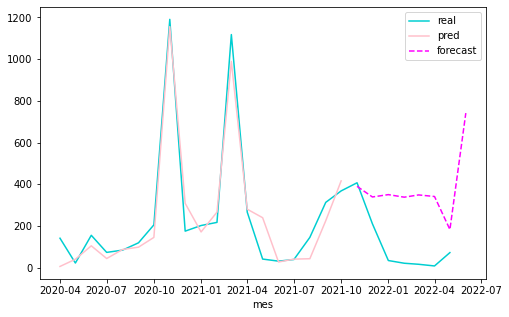

In [67]:
plt.subplots(figsize=(8, 5))

plt.plot(df_result.index, df_result.real, color='darkturquoise', label='real')
plt.plot(df_result.pred_realized, color='pink', label = 'pred')
plt.plot(df_result.forecast, color='magenta', label = 'forecast', linestyle='dashed')
plt.xlabel("mes")
plt.legend()

plt.show()

### Automatizado

In [68]:
periodo = 12
trend_values = ['c','t','ct']
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], periodo) for x in pdq]

result = []

for trend in trend_values:
    for order in pdq:
        for seasonal_order in pdqs:
            try:
                srmx = sarimax.SARIMAX(y_train,
                                      trend=trend,
                                      order=order,
                                      seasonal_order=seasonal_order,
                                      exog=x_train)
                                                      
                modelo = srmx.fit(disp=False)
                pred = modelo.get_forecast(steps=len(x_test), exog=x_test)

                wmape = wmape_metric(y_test, pred.predicted_mean)
                aic = modelo.aic
                bic = modelo.bic

                if wmape > 0:
                    result.append([order,seasonal_order,trend,wmape,aic,bic,modelo])
            except:
                continue

In [69]:
df_params = pd.DataFrame(result, columns=['pdq','pdqs','trend','wmape','aic','bic','modelo'])

df_params.sort_values(by=['wmape'],ascending=True).head(10)

,pdq,pdqs,trend,wmape,aic,bic,modelo
460,"(2, 0, 1)","(1, 0, 1, 12)",c,0.141855,21.795532,31.239922,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
497,"(2, 0, 2)","(2, 0, 2, 12)",c,0.179477,34.329015,46.606722,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
461,"(2, 0, 1)","(1, 0, 2, 12)",c,0.186310,27.279414,37.668243,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1792,"(2, 0, 2)","(2, 0, 1, 12)",ct,0.193712,41.041934,53.319641,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
488,"(2, 0, 2)","(1, 0, 2, 12)",c,0.208133,36.584603,47.917871,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
438,"(2, 0, 0)","(1, 0, 0, 12)",c,0.210805,23.036180,30.591692,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
487,"(2, 0, 2)","(1, 0, 1, 12)",c,0.211235,34.790712,45.179541,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
495,"(2, 0, 2)","(2, 0, 0, 12)",c,0.213743,31.446157,41.834986,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
271,"(1, 0, 2)","(1, 0, 1, 12)",c,0.217938,31.541351,40.985741,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
450,"(2, 0, 1)","(0, 0, 0, 12)",c,0.218662,15.019840,22.575352,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [70]:
#index do modelo escolhido
index_number = 460

#selecionando o modelo
modelo = df_params.loc[df_params.index == index_number].iloc[0,6]

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  visualizacoes_log   No. Observations:                   19
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 12)   Log Likelihood                  -0.898
Date:                            Mon, 13 Jun 2022   AIC                             21.796
Time:                                    19:44:35   BIC                             31.240
Sample:                                04-01-2020   HQIC                            23.394
                                     - 10-01-2021                                         
Covariance Type:                              opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                1.1302      2.919      0.387      0.699      -4.591       6.851
post                     1.4182      0.763      1.859      0.063      -0.077       2.913
lockdown                -0.3449      0.300     -1.151      0.250      -0.932       0.243
impressions_linkedin    -0.2823      0.282     -1.000      0.317      -0.836       0.271
ar.L1                    1.4812      0.772      1.919      0.055      -0.031       2.994
ar.L2                   -0.8600      0.425     -2.024      0.043      -1.693      -0.027
ma.L1                   -0.7596      0.750     -1.012      0.311      -2.230       0.711
ar.S.L12                -0.5069      2.574     -0.197      0.844      -5.551       4.537
ma.S.L12                -0.9380    116.804     -0.008      0.994    -229.870     227.994
sigma2                   0.0154      1.755      0.009      0.993      -3.424       3.455
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.50   Prob(JB):                         0.91
Heteroskedasticity (H):               0.75   Skew:                            -0.24
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
pred = modelo.get_forecast(steps=len(x_test), exog=x_test)

print('aic:', round((modelo.aic),2))
print('bic:', round((modelo.bic),2))
print('wmape:', round(wmape_metric(y_test, pred.predicted_mean),2))

aic: 21.8
bic: 31.24
wmape: 0.14


In [72]:
df_result = to_predict(x_test, df_future)

df_result.tail(10)

,real,pred_realized,forecast,lower visualizacoes_log,upper visualizacoes_log
data,,,,,
2021-09-01,313.0,234.582835,NaN,NaN,NaN
2021-10-01,368.0,294.454329,NaN,NaN,NaN
2021-11-01,407.0,NaN,249.735079,122.623678,508.609843
2021-12-01,210.0,NaN,162.233823,67.924239,387.487788
2022-01-01,34.0,NaN,65.018760,26.926779,156.997583
2022-02-01,21.0,NaN,19.284379,7.791479,47.730001
2022-03-01,16.0,NaN,22.939376,8.486734,62.004416
2022-04-01,8.0,NaN,22.093914,7.571696,64.469181
2022-05-01,72.0,NaN,192.186252,63.675008,580.063618


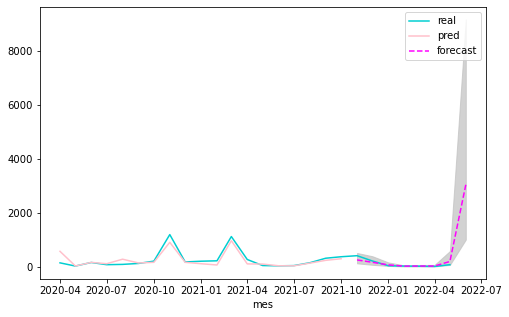

In [73]:
plt.subplots(figsize=(8, 5))

plt.plot(df_result.index, df_result.real, color='darkturquoise', label='real')
plt.plot(df_result.pred_realized, color='pink', label = 'pred')
plt.plot(df_result.forecast, color='magenta', label = 'forecast', linestyle='dashed')
plt.fill_between(df_result.index, df_result['lower visualizacoes_log'], df_result['upper visualizacoes_log'] , color='silver', alpha=0.7)
plt.xlabel("mes")
plt.legend()

plt.show()

In [74]:
df_result.to_csv('result_forecast_views.csv')